In [1]:
#The code I used to generate example data 
# M = np.zeros((300, 4))
# K = np.load(namefile(2,3))
# for i in range(300):
#     M[i,0] = np.random.randint(low = 0, high = Ntimes)
#     M[i,1] = np.random.randint(low = 0, high = N)
#     M[i,2] = np.random.randint(low = 0, high = N)
#     M[i,3] = K[int(M[i,0]),int(M[i,1]),int(M[i,2])]
# M = np.unique(M, axis = 0)
#np.save('Example_data.npy', M)


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm as t
from pathlib import Path
from run_forward_model import generate_model_config, run_model, create_grid

# Fetch simulation data path
namefile = lambda i,j: Path().cwd() / f'data/sample_data_{i}_{j}.npy'



In [43]:
# Loading true data
measurement_data_file = "../data/pm25_processed_1day.npy"
measurement_array = np.load(measurement_data_file)
sorted_array = np.array(sorted(measurement_array, key = lambda x: (x[0], x[1], x[2])))
if (sorted_array != measurement_array).any():
    measurement_array = sorted_array
    print("Measurement array sorted")
tmp, ar = np.unique(measurement_array[:,0:3], axis=0, return_index=True)
measurement_array = measurement_array[ar,:]

Measurement array sorted


In [44]:
# Generate forward model data

#Parameters of the grid
tmax = 600*144
time_step = 600
Nx = Ny = 80
widthx = 110e3
widthy = 220e3
# Model parameters
source_strength = np.array([1.0])
source_locations = np.array([[60, 60]])
velocity_field = np.array([-4.0, -6.0])
diffusion_coefficent = 10.0
sensor_times = np.arange(0, tmax+1, step=600)
Ntimes = len(sensor_times)
# Model config
gb = create_grid(Nx, widthx, Ny, widthy)
model_grid = gb.get_grids()[0]


In [45]:
cell_widthx = widthx / Nx
cell_widthy = widthy / Ny

In [6]:
""" 
DO NOT RUN IF DATA ALREADY EXISTS
"""
for i in range(Nx*Ny):
    source_location = np.atleast_2d(model_grid.cell_centers[:2,i])
    config = generate_model_config(
        Nx = Nx, Ny = Ny,
        widthx = widthx, widthy = widthy,
        time_step = time_step, tmax = tmax,
        source_strength = source_strength,
        source_locations = source_location,
        velocity_field = velocity_field,
        diffusion_coefficent = diffusion_coefficent,
        sensor_times = sensor_times,
    )
    true_data, gb_true = run_model(
        config, save_output=True,
        # coarsegrain_output=True, coarse_grid=model_grid,
        # create_gif=True
    )
    if (i % Nx) == 0:
        print('finished sim ',i,' out of ',Nx*Ny)

finished sim  0  out of  6400
finished sim  80  out of  6400
finished sim  160  out of  6400
finished sim  240  out of  6400
finished sim  320  out of  6400
finished sim  400  out of  6400
finished sim  480  out of  6400
finished sim  560  out of  6400
finished sim  640  out of  6400
finished sim  720  out of  6400
finished sim  800  out of  6400
finished sim  880  out of  6400
finished sim  960  out of  6400
finished sim  1040  out of  6400
finished sim  1120  out of  6400
finished sim  1200  out of  6400
finished sim  1280  out of  6400
finished sim  1360  out of  6400
finished sim  1440  out of  6400
finished sim  1520  out of  6400
finished sim  1600  out of  6400
finished sim  1680  out of  6400
finished sim  1760  out of  6400
finished sim  1840  out of  6400
finished sim  1920  out of  6400
finished sim  2000  out of  6400
finished sim  2080  out of  6400
finished sim  2160  out of  6400
finished sim  2240  out of  6400
finished sim  2320  out of  6400
finished sim  2400  out of

In [46]:
np.isclose(measurement_array[:,0], 6)
sensors_at_t = measurement_array[np.isclose(measurement_array[:,0], 6),:]
sensor_locs = (sensors_at_t[:,[1,2]] * np.array([cell_widthx, cell_widthy]) + np.array([cell_widthx, cell_widthy]) / 2).T
model_grid.closest_cell(sensor_locs)

array([5689, 5291, 4336, 3860, 3541, 3623, 3703, 4183, 5143, 3224, 3544,
       2666, 3786, 3068, 3468, 2989, 1950, 3470, 2192, 2592, 2355, 3796,
       3637, 4517, 1558, 4758, 5079, 5479, 3400, 3242,  364, 4124,  125,
         46, 2128, 3008, 2533, 2376, 2377, 1738, 1499, 3825, 3427, 3116,
        158])

In [84]:
def weighted_norm(Sigma_inv, x):
    return x.T@Sigma_inv@x

def compute_posterior(prior, measurement_array, Sigma_noise, scaling=1.0, preload_sim_data=None):

    if preload_sim_data is None:
        #Will load the matrices from disk
        #I build the mask first
        measurement_mask = np.zeros((Ntimes, Nx, Ny)).astype(bool)
        for i in range(len(measurement_array)):
            measurement_mask[int(measurement_array[i,0]), int(measurement_array[i,1]), int(measurement_array[i,2])] = True
        get_hypothetical = lambda i,j: np.load(namefile(i,j)).reshape(Ntimes,Nx,Ny)[measurement_mask]
    else:
        #preload_sim_data has to be (N,N,N_measurements)
        get_hypothetical = lambda i,j: preload_sim_data[i,j]
    
    data = measurement_array[:, -1] 
    
    Sigma_inv = np.linalg.inv(Sigma_noise)
    posterior = np.zeros((Nx,Ny))
    #I'm not sure if this can be vectorized more since I have to individually open and close files
    for i in t(range(Nx)):
        for j in range(Ny):
            #Compute prob(data|source is in (i,j))
            #Compute first true observations that would have happened if the source was in (i,j)
            hypothetical_observations = get_hypothetical(i,j)*scaling
            posterior[i,j] = prior[i,j]*np.exp(-1/2 * weighted_norm(Sigma_inv, data-hypothetical_observations))
    s = np.sum(posterior)
    posterior/= s
    return posterior

In [89]:
i = 40
j = 40
Sigma_inv = np.linalg.inv(Sigma_noise)
hypothetical_observations = get_hypothetical(i,j)
data = measurement_array[:, -1] 
p = prior[i,j]*np.exp(-1/2 * weighted_norm(Sigma_inv, data-hypothetical_observations))
p

0.0

In [93]:
#How much noise do we assume that the measurements had? In units of the measurements
#Assuming here that all the sensors are independent and with the same noise
n_measurements = measurement_array.shape[0]
sigma = 1.0 
Sigma_noise = sigma**2*np.eye(n_measurements) 

# Scale the theoretical data
i = 60
j = 60
hypothetical_observations = get_hypothetical(i,j)
data = measurement_array[:, -1] 
scaling = np.mean(data)/np.mean(hypothetical_observations)

In [94]:
posterior = compute_posterior(prior = prior, measurement_array=measurement_array, Sigma_noise=Sigma_noise, scaling=scaling)

  0%|          | 0/80 [00:00<?, ?it/s]

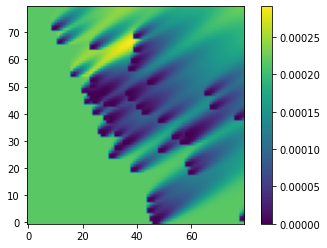

In [102]:
casename = "case_runs/80x80_realdata_posterior_uniform_sigma1_0"
plt.imshow(posterior)
plt.colorbar()
plt.gca().invert_yaxis()
plt.savefig(casename + ".png")
np.save(casename + ".npy", posterior)

In [97]:
np.save("80x80_realdata_posterior_uniform_sigma1_0.npy", posterior)

In [55]:
posterior

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])